In [1]:
import torch 
import torchvision 


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu" 

In [3]:
def set_seed(seed=42): 
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)

In [4]:
from pathlib import Path 

image_path = Path("data/pizza_steak_sushi/")

train_dir = image_path / "train" 
test_dir = image_path / "test" 

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [5]:
from torchvision import transforms 

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # transforms.ToTensor()
])

manual_transforms 

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [7]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 

model = torchvision.models.efficientnet_b0(weights=weights).to(device) 
model.classifier 

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [8]:
auto_transforms = weights.transforms() 
auto_transforms 

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
from going_modular import data_setup 

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, auto_transforms, 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x236b1a349d0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
for param in model.features.parameters(): 
    param.requires_grad = False 
    

In [11]:
from torch import nn 

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(in_features=1280, out_features=len(class_names)) 
).to(device) 

In [12]:
from torchinfo import summary 

summary(model, 
        input_size=(32, 3, 224, 224), 
        verbose=0, 
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        col_width=20, 
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [13]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [14]:
from torch.utils.tensorboard import SummaryWriter 

writer = SummaryWriter() 
writer 

In [15]:
from going_modular.engine import train_step, test_step 

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):  
   
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []} 
    
    for epoch in range(epochs): 
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device) 
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device) 
        
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | " 
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}") 
        
        results["train_loss"].append(train_loss) 
        results["train_acc"].append(train_acc) 
        results["test_loss"].append(test_loss) 
        results["test_acc"].append(test_acc)  
        
        
        writer.add_scalars(
            main_tag="Loss", 
            tag_scalar_dict={"train_loss": train_loss, 
                             "test_loss": test_loss}, 
            global_step=epoch) 
        
        writer.add_scalars(
            main_tag="Accuracy", 
            tag_scalar_dict={"train_acc": train_acc, 
                             "test_acc": test_acc}, 
            global_step=epoch) 
        
        writer.add_graph(model=model, 
                         input_to_model=torch.randn(32, 3, 244, 244).to(device)) 
        
    writer.close()  
        
    return results 

In [16]:
set_seed() 
results = train(model=model, 
                train_dataloader=train_dataloader, 
                test_dataloader=test_dataloader, 
                optimizer=optimizer, 
                loss_fn=loss_fn, 
                epochs=5, 
                device=device)

Epoch: 1 | train_loss: 1.0946 | train_acc: 0.4023 | test_loss: 0.9456 | test_acc: 0.6818
Epoch: 2 | train_loss: 0.9087 | train_acc: 0.6445 | test_loss: 0.8419 | test_acc: 0.6723
Epoch: 3 | train_loss: 0.7981 | train_acc: 0.7500 | test_loss: 0.6751 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7111 | train_acc: 0.7500 | test_loss: 0.7000 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.6245 | train_acc: 0.7891 | test_loss: 0.6836 | test_acc: 0.7945


In [17]:
# %load_ext tensorboard
# # %reload_ext tensorboard 
# %tensorboard --logdir runs 

In [18]:
import os 
from datetime import datetime 

def create_writer(experiment_name, model_name, extra): 
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific experiment"""
    timestamp = datetime.now().strftime("%y-%m-%d") 
    
    if extra: 
        log_dir = os.path.join("runs", timestamp, experiment_name, extra)
    else: 
        log_dir = os.path.join("runs", timestamp, experiment_name) 
        
    print(f"[INFO] Created SummaryWriter saving to {log_dir}")
        
    return SummaryWriter(log_dir=log_dir) 

In [19]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, writer):  
   
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []} 
    
    for epoch in range(epochs): 
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device) 
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device) 
        
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | " 
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}") 
        
        results["train_loss"].append(train_loss) 
        results["train_acc"].append(train_acc) 
        results["test_loss"].append(test_loss) 
        results["test_acc"].append(test_acc)  
        
        
        if writer: 
            writer.add_scalars(
                main_tag="Loss", 
                tag_scalar_dict={"train_loss": train_loss, 
                                "test_loss": test_loss}, 
                global_step=epoch) 
            
            writer.add_scalars(
                main_tag="Accuracy", 
                tag_scalar_dict={"train_acc": train_acc, 
                                "test_acc": test_acc}, 
                global_step=epoch) 
            
            writer.add_graph(model=model, 
                            input_to_model=torch.randn(32, 3, 244, 244).to(device)) 
        
            writer.close()  
        else: 
            pass 
        
    return results 

In [21]:
data_10_percent = Path("data/pizza_steak_sushi")
data_20_percent = Path("data/pizza_steak_sushi_20_percent")  

train_dir_10_percent = data_10_percent / "train" 
train_dir_20_percent = data_20_percent / "train" 

test_dir = data_10_percent / "test"


In [23]:
BATCH_SIZE = 32 

train_dataloader_10_percent, test_dataloader_10_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent, 
                                                                                                     test_dir=test_dir, 
                                                                                                     transform=auto_transforms, 
                                                                                                     batch_size=BATCH_SIZE) 

train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, 
                                                                                                     test_dir=test_dir, 
                                                                                                     transform=auto_transforms, 
                                                                                                     batch_size=BATCH_SIZE) 

print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}") 


Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15


In [24]:
import torchvision 

effinetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 
effinetb2 = torchvision.models.efficientnet_b2(weights=effinetb2_weights) 
effinetb2.classifier 

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\jusung/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 37.6MB/s]


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [25]:
OUT_FEATURES = len(class_names) 

def create_effinetb0(): 
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
    model = torchvision.models.efficientnet_b0(weights=weights).to(device) 
    
    for param in model.features.parameters(): 
        param.requires_grad = False 
        
    set_seed() 
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True), 
        nn.Linear(in_features=1280, out_features=OUT_FEATURES) 
    ).to(device) 
    
    model.name = "effnetb0" 
    print(f"[INFO] Create new {model.name} model...") 
    
    return model 

In [26]:
def create_effinetb2(): 
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 
    model = torchvision.models.efficientnet_b2(weights=weights).to(device) 
    
    for param in model.features.parameters(): 
        param.requires_grad = False 
        
    set_seed() 
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True), 
        nn.Linear(in_features=1408, out_features=OUT_FEATURES) 
    ).to(device) 
    
    model.name = "effnetb2" 
    print(f"[INFO] Create new {model.name} model...") 
    
    return model 

In [27]:
effinetb0 = create_effinetb0() 

summary(effinetb0, 
        input_size=(32, 3, 224, 224), 
        verbose=0, 
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        col_width=20, 
        row_settings=["var_names"]
        )

[INFO] Create new effnetb0 model...


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [28]:
effinetb2 = create_effinetb2() 

summary(effinetb2, 
        input_size=(32, 3, 224, 224), 
        verbose=0, 
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        col_width=20, 
        row_settings=["var_names"]
        )

[INFO] Create new effnetb2 model...


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [30]:
num_epochs = [5, 10] 

models = ["effnetb0", "effnet2"] 

train_dataloaders = {"data_10_percent": train_dataloader_10_percent, 
                    "data_20_percent": train_dataloader_20_percent} 

In [31]:
from going_modular.utils import save_model 

set_seed(seed=42) 

experiment_number = 0 

for dataloader_name, train_dataloader in train_dataloaders.items(): 
    for epochs in num_epochs: 
        for model_name in models: 
            
            experiment_number += 1 
            print(f"[INFO] Experiment number: {experiment_number}") 
            print(f"[INFO] Model: {model_name}") 
            print(f"[INFO] DataLoader: {dataloader_name}") 
            print(f"[INFO] Number of epochs: {epochs}") 
            
            if model_name == "effnetb0": 
                model = create_effinetb0() 
            else: 
                model = create_effinetb2() 
                
            loss_fn = nn.CrossEntropyLoss() 
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001) 
            
            # train target model and track experiments 
            train(model=model, 
                  train_dataloader=train_dataloader, 
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer, 
                  loss_fn=loss_fn, 
                  epochs=epochs, 
                  device=device, 
                  writer=create_writer(experiment_name=dataloader_name, 
                                       model_name=model_name, 
                                       extra=f"{epochs}_epochs")) 
            
            # save the model 
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth" 
            save_model(model=model, target_dir="saved_models", model_name=save_filepath)
            print("-"*50 + "\n")
            
            
            

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Create new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\24-03-12\data_10_percent\5_epochs
Epoch: 1 | train_loss: 1.0552 | train_acc: 0.4805 | test_loss: 0.8709 | test_acc: 0.6818
Epoch: 2 | train_loss: 0.8992 | train_acc: 0.5898 | test_loss: 0.8043 | test_acc: 0.6922
Epoch: 3 | train_loss: 0.7991 | train_acc: 0.6797 | test_loss: 0.6483 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.6869 | train_acc: 0.8828 | test_loss: 0.6164 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6340 | train_acc: 0.8438 | test_loss: 0.6240 | test_acc: 0.8352
[INfO] Saving model to: saved_models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnet2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Create new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\24-03-

In [42]:
best_model_path = "saved_models/07_effnet2_data_20_percent_10_epochs.pth" 

best_model = create_effinetb2() 

best_model.load_state_dict(torch.load(best_model_path)) 

[INFO] Create new effnetb2 model...


<All keys matched successfully>

In [43]:
# get the model size in bytes then convert it to megabytes 
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024) 
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} Size")

EfficientNetB2 feature extractor model size: 29 Size


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


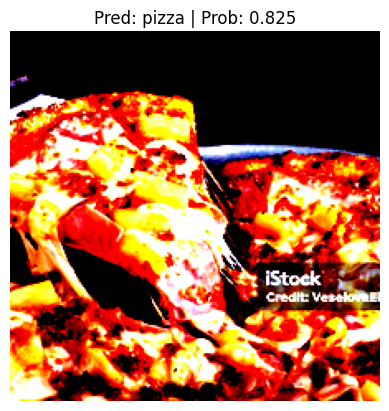

In [44]:
from helper_functions import pred_and_plot_image 

# custom_image_transform = transforms.Compose([
#     transforms.Resize(size=(64, 64))
# ])
custom_image_path = 'data/pizza_image_1024.jpg'

pred_and_plot_image(best_model, custom_image_path, class_names, auto_transforms, device) 